## ASTR 21000, Winter 2020

## Homework Assignment 4 (55 points + 15 extra-credit points)

## Drawing samples from distribution and implementing Differential Evolution minimization

### Olina Liang

In [19]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plot_utils import plot_pretty
plot_pretty(fontsize=12)
from codes.constants import clight
from codes.cosmology import d_L_vectorized

### Exercise 1 (10 points): drawing pseudo-random integers and Gaussian pseudo-random numbers.

**Background.** During the past weeks (as well as before) we have encountered algorithms that rely on drawing random numbers with a given distribution. Most common case is random numbers, either integer or real, that are *uniformly distributed* within a given range. Uniform distribution means that all numbers within range have equal probability to be drawn, so for example, if we randomly draw uniformly distributed integers from 0 to 10, all numbers 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 will be drawn equal number of times after sufficiently large number of draws. 

In particular, in the *random walk* and *differential evolution* algorithms i described in class on Friday (see <a href="05_optimization.ipynb"><tt>05_optimization.ipynb</tt></a> notebook) random samples (draws) from Gaussian and uniform distribution are used.  

**Task 1a. (3 points)** <tt>nrand</tt> random intergers distributed uniformly in the range <tt>imin</tt> to <tt>imax</tt> can be drawn using routine <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.random_integers.html">numpy.random.random_integers<tt></tt></a>  as

        irand = np.random.random_integers(low=imin, high=imax, size=nrand)

where <tt>irand</tt> will be a vector of randomly drawn integers in the required range. Use this function to generate <tt>nrand=10</tt>, <tt>nrand=20</tt>, <tt>nrand=30</tt> numbers in the range from 0 to <tt>nrand-1</tt> and print them out. Examine the numbers and comment on their properties: do they look random? do the numbers repeat (if so, is this ok or no)? Comment on whether this function can be used to generate indices <tt>ir1, ir2, ir3</tt> unique and different from <tt>i</tt> in the DE algorithm shown above, and, if so, how would you do this. 

Note: numpy has another routine <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randint.html"><tt>numpy.random.randint</tt></a> to generate random integers, but this routine generates numbers excluding <tt>imax</tt>, i.e. in the semi-open interval <tt>[imin,imax)</tt>. 

- I'm using numpy.random.randint because random.random_integers gives the DeprecationWarning.
- The numbers look random by looking at the histograms because they are uniform. But the numbers do repeat, which means they can't be used to generate unique random indices different from each other directly. Possible way to deal with this is to just run the generator again when the number repeated.

In [70]:
def test_rand(func, args, n_samples):
    imin, imax, nrand = args
    i = 0
    l = np.array([])
    while i < n_samples:
        l = np.concatenate((l, func(imin, imax, nrand)), axis = None)
        i += 1
    return l

[9 6 6 8 0 6 0 7 5 4]


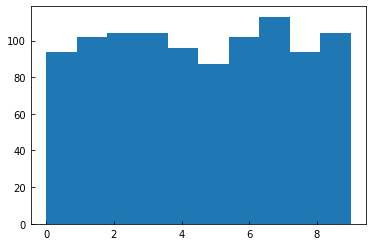

In [74]:
nrand = 10
print(np.random.randint(0, nrand, nrand))
a = plt.hist(test_rand(np.random.randint, [0, nrand, nrand], 100), bins = nrand)

[19  6  3  3  4  1  6 10  5  7 15 15 10  0  9  5  8  3 18  4]


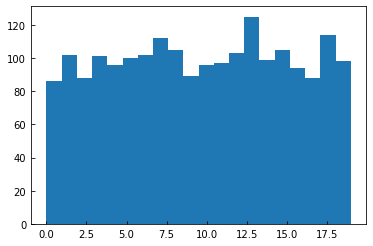

In [75]:
nrand = 20
print(np.random.randint(0, nrand, nrand))
a = plt.hist(test_rand(np.random.randint, [0, nrand, nrand], 100), bins = nrand)

[24 14  9 17 21  9 15 11 14 28 29 10 22  3 22 16 26 16 17  9 14  5 13 17
 22 25  1  8 26  3]


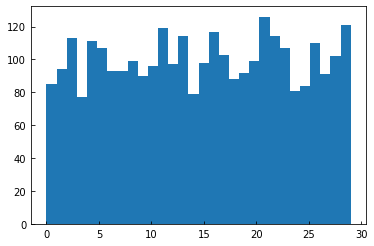

In [82]:
nrand = 30
print(np.random.randint(0, nrand, nrand))
a = plt.hist(test_rand(np.random.randint, [0, nrand, nrand], 100), bins = nrand)

**Task 1b. (2 points)** Another possibility of producing indices <tt>ir1, ir2, ir3</tt> is to take an ordered list of integer numbers from 0 to <tt>npop-1</tt> and randomly *permute* its elements using numpy function <a href="https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.permutation.html"><tt>numpy.random.permutation</tt></a>. Experiment with this function for a vector of a small size (say 10) and examine its effect on the order of the vector elements. Develop an algorithm of producing  <tt>ir1, ir2, ir3</tt> indices for the DE algorithm using this function. Do you see any advantages or disadvantages of this method over the method discussed in 1a? 

- From looking at the histogram, we see the permutation gives random position of each number everytime. It also makes sure that ir1, ir2 and ir3 are unique which makes it easier to implement than numpy.random.randint. Possible disadvantage to 1a might be that it computes all 10 numbers when we only need 3.

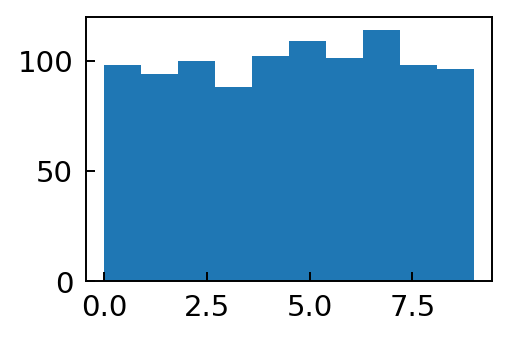

In [40]:
# test the possibilities of the postion of 1, other numbers have similar histogram
npop = 10
lst = np.arange(npop)
i = 0
l = []
while i < npop * 100:
    i += 1
    p = np.random.permutation(lst)
    l.append(np.where(p == 1)[0][0])
plt.figure(figsize=(3, 2)) 
a = plt.hist(l, bins = npop)

**Task 1c (5 points).** Gaussian random numbers to produce stochastic scaling parameter $s$ can be drawn using routine <a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html"><tt>numpy.random.normal</tt></a>. For example to produce <tt>nrnd</tt> pseudo-random draws from a Gaussian distribution with the mean <tt>mu</tt> and dispersion <tt>sigma</tt> we use

    xgauss = np.random.normal(loc=mu, scale=sigma, size=nrnd)
    
Random numbers are samples drawn from a given probability distribution function (pdf), if the probability density of the draws is described by the pdf function. Thus, we can generate a sufficiently large number of pseudo-random numbers using <a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html"><tt>numpy.random.normal</tt></a>, as shown above, and then test whether they follow a Gaussian distribution. Namely, we can construct their histogram, which is the density of samples per histogram bins, and check whether the histogram is described by the Gaussian distribution: 

$$p_{\rm G}(x) =\frac{1}{\sqrt{2\pi}\sigma}\, \exp\left[-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right].$$

Choose the number of bins that should be appropriate for such bins and estimate the required number of random draws using what you learned about histogram binning previously, and explain your choice. Generate the corresponding number of random draws, histogram them and compare with the equation for the Gaussian pdf above.

- 1000 randoms draws are chosen, for the data to be somewhat consistent with the disctribution its being drawn from. Also 20 bins are chosen for the histogram to show a random shape but too much of random noise.

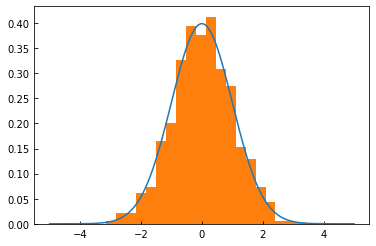

In [108]:
def gaussian_distr(x, miu, sigma):
    n1 = 1/np.sqrt(2*np.pi*sigma)
    n2 = np.exp(-1/2*((x - miu)/sigma)**2)
    return n1*n2

x = np.linspace(-5, 5, 1000)
y = gaussian_distr(x, 0, 1)
plt.plot(x, y)

nrand = 10
ntimes = 100
l = test_rand(np.random.normal, [0, 1, nrand], ntimes)
a = plt.hist(l, density=True, bins = 20)

### Exercise 2 (20 points): drawing pseudo-random numbers following a given distribution.

**Background: the inverse transform method.** There is a class of algorithms to generate random numbers drawn from a given distribution function. All of these algorithms are based on the algorithm to generate uniformly distributed random numbers that is described in <a href="06a_prngs.ipynb"><tt>06a_prngs.ipynb</tt></a> notebook and will be discussed in class on Wednesday. 

One of the most commonly used algorithms to draw samples from a given 1-dimensional distribution $p(x)$ is called *the inverse transform method,* which uses the cumulative distribution function of the target pdf $p(x)$ normalized to 1 at some interval $[a,b]$ that we want to sample:

$$F(\xi) = \int\limits_{a}^\xi p(x) dx;\ \ \ \mathrm{where}\ \ \xi\in[a,b],\ F\in[0,1],\ \ \mathrm{and}\ \  \int\limits_a^b p(x)dx =1$$

to generate samples of $p(x)$. Namely, if $y=F(\xi)$ can be inverted either analytically or numerically so that we can easily compute $\xi$ given a value of $y=F(\xi)$, then $\xi$ will be samples of $p(x)$, if $y$ are samples of the uniform distribution defined on the interval $[0,1)$. 

See <a href="06c_distribution_sampling.ipynb"><tt>06c_distribution_sampling.ipynb</tt></a> notebook for details on the history and logic behind this method. 

**Task 2a (10 points).** 
Write a routine to sample the following distribution that depends on parameter $a$: 

$$g(x)=
 \begin{cases}
            1/\sqrt{x},&\  \mathrm{for}\ \ x\in[1/a,a],\\
            0, &    \mathrm{otherwise.\ }
    \end{cases}$$
    
Note that the above distribution is *not* a pdf, because it is not normalized to 1.0 on the interval $[1/a,a]$. Thus, you should compute the normalization constant first. You should also compute the cumulative distribution function $F(x)$ for the normalized $\tilde{g}(x)$ and its inverse.   

Your routine should take as input parameter $a$ and the number of samples, $N_s$, to be generated and return a vector of $N_s$, pseudo-random numbers distributed with $g(x)$ distribution.
    
For efficiency, your routine must be written using numpy vector operations and should not use loops. 

The vector of <tt>nrnd</tt> uniformly distributed pseudo-random numbers in the interval $[0,1)$ can be generated using routine <a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.uniform.html"><tt>numpy.random.uniform</tt></a> as 
    
    yrnd = np.random.uniform(size=nrnd)

Note that the sampling routine you develop here will be used in the implementation of the "affine-invariant" Markov Chain Monte Carlo (MCMC) sampling method of Goodman & Weare as part of the homework 4 assignment.  This is yet another example of a simpler method problem used as an element of a more complex algorithm. 

- First we calculate the inverse numerically.

- The integral of the g(x) function is:

$$\int\limits_{1/a}^a g(x) dx 
= \int\limits_{1/a}^a \dfrac{1}{\sqrt{x}} dx 
= 2{x^{1/2}} \Big|_{1/a}^a 
= 2(a^{1/2} - {1/a}^{1/2}) $$

- To normalize, we let $c = 2(a^{1/2} - {1/a}^{1/2})$ and divide by c

$$p(x)=
 \begin{cases}
            \dfrac{1}{c\sqrt{x}},&\  \mathrm{for}\ \ x\in[1/a,a]\\
            0, &    \mathrm{otherwise\ }
    \end{cases}$$

- The analytic solution of $F^{-1}(\xi)$ is:

$$F(\xi) = \int\limits_{1/a}^\xi p(x) dx = \int\limits_{1/a}^\xi \dfrac{1}{c\sqrt{x}} dx = \dfrac{2}{c}x^{1/2} \Big|_{1/a}^\xi = \dfrac{2}{c}(\xi^{1/2} - {1/a}^{1/2}) $$

$$F^{-1}(\xi) = (\dfrac{cy}{2} + \dfrac{1}{\sqrt{a}})^2$$

In [131]:
#Inverse of p(x) from g(x)
def g_inv(y, a):
    assert a > 1, "a should be greater than 1"
    c = 2*(a**(1/2) - (1/a)**(1/2))
    return (c*y/2 + 1/np.sqrt(a))**2

In [156]:
def gdist(nrnd = 1, a = 2.0):
    '''
    function to sample distribution g(x) = 1/sqrt(x) for x in [1/a,a] and g(x)=0 otherwise.
    
    Parameters:
    -----------
    nrnd(integer, default is 1): number of pseudo-random draws of g(x) to generate
    a(float): parameter defining the range of the distribution (see above
       
    Returns: 
    --------
    a numpy real 1d vector of size nrnd
    (pseudo-random numbers distributed with g(x), as defined above 
    '''
    yrnd = np.random.uniform(size = nrnd)
    return np.apply_along_axis(lambda y: g_inv(y, a = a), axis = 0, arr = yrnd)

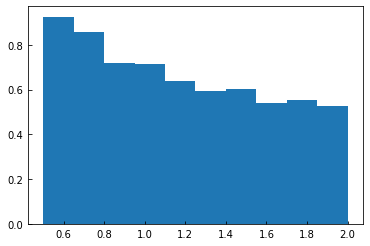

In [157]:
a = plt.hist(gdist(nrnd = 10000), density = True)

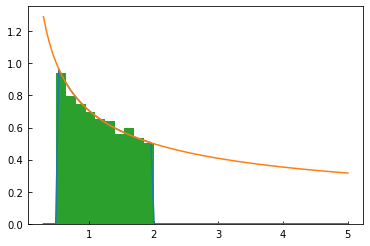

In [158]:
#define the g(x) function to check result
def g(x, a):
    assert a > 1, "a should be greater than 1"
    if 1/a <= x <= a:
        return 1/np.sqrt(x)
    else:
        return 0
g = np.vectorize(g, otypes=[np.float64])

a = 2
c = 2*(a**(1/2) - (1/a)**(1/2))
x = np.linspace(0.3,5,100)
y = g(x, a)/c
plt.plot(x, y)
plt.plot(x, 1/np.sqrt(x)/c)
a = plt.hist(gdist(nrnd = 10000), density = True)

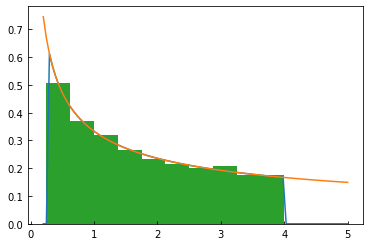

In [160]:
#define the g(x) function to check result
def g(x, a):
    assert a > 1, "a should be greater than 1"
    if 1/a <= x <= a:
        return 1/np.sqrt(x)
    else:
        return 0
g = np.vectorize(g, otypes=[np.float64])

a = 4
c = 2*(a**(1/2) - (1/a)**(1/2))
x = np.linspace(0.2,5,100)
y = g(x, a)/c
plt.plot(x, y)
plt.plot(x, 1/np.sqrt(x)/c)
a = plt.hist(gdist(nrnd = 10000, a = 4), density = True)

- Blue lines shows the normalized piecewise function, orange lines shows the normalized function of $1/\sqrt{x}$, green line shows the random sample distribution. We can see that they coincide, showing that the function draws random numbers from the desired pdf.

**Task 2b (10 points).** Suppose we want to draw samples from a more complicated pdf, $p(x) = A x^{-\alpha}\exp[-x/b]$, for which cumulative distribution function cannot be inverted analytically. 

- To calculate the integral, we can use the polynomial method in hw2.

In [290]:
#all from hw2
def cubic_spline_coefficients(xi, fi):
    """
    compute coefficients of the interpolating natural cubic spline
    see Appendix in the note for the derivation and details of the algorithm
    
    Parameters:
        xi, fi: numpy float vectors
                tabulated points and function values
            
    Returns:
        a, b, c, d: numpy float vectors
                cubic spline coefficients 
                dx = x - xi[i]
                fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)
    """
    delx = np.diff(xi); delf = np.diff(fi)
    vx = np.zeros_like(xi)
    vx[1:-1:] = 3.*(delf[1::]/delx[1::] - delf[:-1:]/delx[:-1:])
    nx = np.size(xi)
    diags = np.zeros((3, nx))
    diags[1,0] = 1.; diags[1,-1] = 1.
    diags[1,1:-1:] = 2. * (delx[1::] + delx[:-1:])
    diags[0,1:] = delx[:]
    diags[2,1:-1] = delx[1:]
    ac, bc, cc, dc = map(np.array, (diags[0,:], diags[1,:], diags[2,:], vx)) # copy arrays
    for k in range(1, nx):
        mk = ac[k] / bc[k-1]
        bc[k] = bc[k] - mk * cc[k-1] 
        dc[k] = dc[k] - mk * dc[k-1]
    c = np.zeros_like(bc)
    c[-1] = dc[-1] / bc[-1]
    for k in range(nx-2, -1, -1):
        c[k] = (dc[k]-cc[k]*c[k+1])/bc[k]
    b = delf[::]/delx[::] - (c[1::] + 2.*c[:-1:])*delx[::]/3.
    d = (c[1::] - c[:-1:])/(3.*delx[::]) 
    a = fi
    return a, b, c, d

def cubic_spline(xt, xi, a, b, c, d):
    """
    piecewise linear approximation of f(x) given input of tabulated values of xi and fi
    note that xi are expected in ascending order
    
    Returns:
        vector of spline values at test points x 
    """
    n = np.size(xi) - 1
    fxt = np.empty_like(xt)
    for j, x in enumerate(xt):
        for i in range(n):
            if (x >= xi[i]) and (x <= xi[i+1]):
                # reusing computations is always a good idea, but here we also can return dfdx
                dx = x - xi[i]
                fxt[j] = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)
    return fxt

def get_integral(xi, a, b, c, d):
    """
    Calculate the integral of cubic spline.
    Inputs:
    xi: list of x values
    a, b, c, d: list of coefficients for the polynomial interpolation
    
    Returns a list of yi values for the integrated function.
    """
    x = []
    y = []
    integral = 0
    for i in range(0,len(xi) - 1):
        x1 = xi[i]
        x2 = xi[i + 1]
        d12 = x2 - x1
        s = d12*(a[i] + d12*(1/2*b[i] + d12*(1/3*c[i] + d12*1/4*d[i])))
        integral += s
        x.append(x2)
        y.append(integral)
    return (np.array(x), np.array(y))

In [347]:
#define the distribution function
def p(x, A, alpha, b):
    return A*x**(-alpha)*np.exp(-x/b)

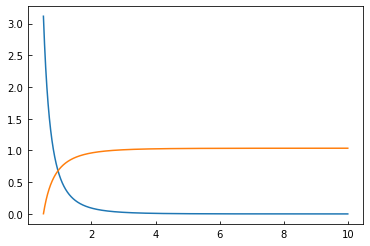

In [333]:
#show the integration of pdf works
xmin, xmax = 0.5, 10
ntr = int(xmax - xmin) * 1000
A, alpha, b = 1, 2, 2

xtr = np.linspace(xmin, xmax, ntr)
ftr = np.apply_along_axis(lambda x: p(x, A, alpha, b), axis = 0, arr = xtr) 
a, b, c, d = cubic_spline_coefficients(xtr, ftr)
xt = np.linspace(xmin, xmax, ntr)
spline_int = cubic_spline(xt, xtr, a, b, c, d)

x, y = get_integral(xtr, a, b, c, d)
y/y.max() #normalize

plt.plot(xtr, ftr) #blue, original function
plt.plot(x, y) #orange, nomalized cdf

- To invert the equation, we could use the spline technique in hw2, by sampling points from the distribution and inverting them, them connecting the points with splines. 

In [307]:
#hw2
def invert_func_spline(xtr, ftr, xt):
    """
    Uses spline approach to invert a function by estimating x for y.
    
    Parameters:
    -----------
    xtr, ftr: array like
            vectors of training points and tabulated function values
    xt: array like
            vector of test points
    Returns:
    --------
    ft: array like
        f-1 values of the polynomial at xt 
    a:  array like
        polynomial coefficients
    """
    V = np.vander(ftr, N =  np.size(ftr), increasing = True) #Vandermonde matrix
    a = np.linalg.solve(V, xtr) #solve for polynomial coefficients vector a, as a = V^{-1}f
    pfit = np.poly1d(a[::-1]) 
    ft = pfit(xt)
    return ft, a

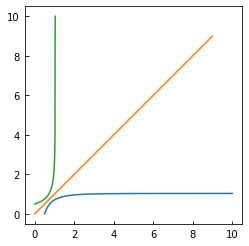

In [334]:
#showing that the inversion works
xtr, ftr = x, y
xt = np.linspace(ftr.min(), ftr.max(), 100)
ft, a = invert_func_spline(xtr, ftr, xt)

plt.gca().set_aspect('equal', adjustable='box')
plt.plot(xtr, ftr) #blue, original cdf
plt.plot(np.arange(10), np.arange(10)) #x = y line
plt.plot(xt, ft) #green, inverted cdf

- Combining the above together in a function and test, we can see that the distribution looks similar to the original one.

In [361]:
def pdist(nrnd = 1, A = 1, alpha = 2, b = 2, xmin = 0.5, xmax = 10.):
    '''
    Function to sample distribution p(x)=Ax^(-a)exp(-x/b).
    
    Parameters:
    -----------
    nrnd(integer, default is 1): number of pseudo-random draws of p(x) to generate
    A, alpha, b(float): parameter for the distribution
    xmax(float): since the distribution has a range of infinity, set the cutoff of x to lim
       
    Returns: 
    --------
    a numpy real 1d vector of size nrnd
    (pseudo-random numbers distributed with p(x), as defined above 
    '''
    assert xmin > 0, "xmin should be greater than 0"
    assert xmax > xmin, "xmax should be greater than xmin"  
    ntr = int(xmax - xmin) * 1000
    xtr = np.linspace(xmin, xmax, ntr)
    ftr = np.apply_along_axis(lambda x: p(x, A, alpha, b), axis = 0, arr = xtr) 
    a, b, c, d = cubic_spline_coefficients(xtr, ftr)
    xt = np.linspace(xmin, xmax, ntr)
    x, px = get_integral(xtr, a, b, c, d)
    px/px.max() #normalize
    
    rand = np.random.uniform(size = nrnd)
    prand, a = invert_func_spline(x, px, rand)
    
    return prand

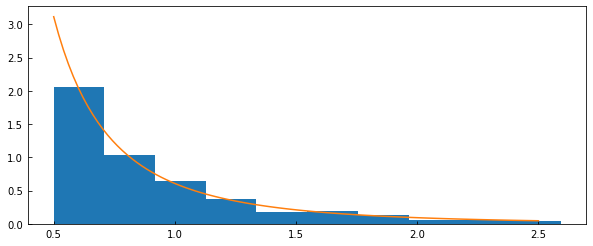

In [365]:
plt.figure(figsize=(10, 4))

t = pdist(nrnd = 1000)
a = plt.hist(t, density = True)

xmin, xmax, ntr = 0.5, 2.5, 100
A, alpha, b = 1, 2, 2
x = np.linspace(xmin, xmax, ntr)
px = np.apply_along_axis(lambda x: p(x, A, alpha, b), axis = 0, arr = x) 
plt.plot(x, px)

- The pdf and the histogram of random draws coincide, which shows that the function works.

### Exercise 3: implementing and testing a Differential Evolution algorithm (25 points + 10 extra-credit points)

**Background.** Minimization in many dimensions is generally a complicated task. However, a class of <a href="https://en.wikipedia.org/wiki/Differential_evolution">Differential Evolution</a> (DE) algorithms developed from the initial ideas of R. Storn and K. Price in 1997 (<a href="https://link.springer.com/article/10.1023%2FA%3A1008202821328">Storn & Price 1997</a>), are relatively simple to implement, work in arbitrary number of dimensions, do not require function derivatives, allow imposing bounds on the domain, and are quite efficient in minimizing multi-dimensional functions.

**Task 3a. (20 points)** Use pseudo-code of the DE algorithm in exercise 1 to implement DE minimization routine with the following interface (15 points):

    def minimize_by_differential_evolution(func, x0, atol=1.e-6, s=1.0, sigs=0.1, bounds=None):
        """
        Parameters:
        ------------
        func - Python function object
               function to minimize, should expect x0 as a parameter vector
        x0   - vector of real numbers of shape (npop, nd), 
                where npop is population size and nd is the number of func parameters
        atol - real
                absolute tolerance threshold for change of population member positions
        s    - real 
                mean of the scaling parameter s
        sigs - real 
                rms dispersion of s for drawing Gaussian random numbers center on s
        bounds - array of tuples 
                bounds for the minimization exploration; define the region in which to search for the minimum
        """
        
Try to "vectorize" as much of the algorithm as possible.
        
Assuming that we are searching for a minimum within some rectangular domain defined by the minimum and maximum values along each coordinate axis: $\mathbf{x}_{\rm min}$ and $\mathbf{x}_{\rm max}$, we can initialize the population members as 

$$\mathbf{x}_0 = \mathbf{x}_{\rm min} + (\mathbf{x}_{\rm max}-\mathbf{x}_{\rm min}) \times \mathrm{rand}(0,1),$$

where $\mathrm{rand}(0,1)$ is a random number uniformly distributed from 0 to 1, generated using <tt>np.random.uniform</tt>.  

Test your implementation in 2D and 5D using the Rosenbrock function similarly how optimization routines were tested in the <a href="05_optimization.ipynb"><tt>05_optimization.ipynb</tt></a> notebook and present results of your tests along with your implementation (2 points). 

Experiment with the size of the population and values of the parameter $s$ timing how long it takes your function to find the minimum. Are the results robust to population size and $s$? Briefly describe results of your findings (3 points). If you do not succeed implementing routine fully, you can still do this part of the task using routine <tt>scipy.optimize.differential_evolution</tt>, as illustrated in the <a href="05_optimization.ipynb"><tt>05_optimization.ipynb</tt></a> notebook.

In [59]:
#helper functions for minimize_by_differential_evolution
def test_boundaries(xtry, bounds):
    '''
    Check if xtry are within bounds.
    '''
    if bounds == None:
        return True
    i = 0
    for par in xtry:
        if par < bounds[i][0] or par > bounds[i][1]:
            return False
        i += 1
    return True

def generate_x0(bounds, npop):
    x0 = []
    i = 0
    while i < npop:
        x0i = []
        for b in bounds:
            x0i.append(b[0] + (b[1] - b[0])*np.random.uniform())
        i += 1
        x0.append(x0i)
    return np.array(x0)

In [49]:
def minimize_by_differential_evolution(func, npop, bounds, atol=1.e-6, s=1.0):
    """
    Parameters:
    ------------
    func - Python function object
            function to minimize, should expect x0 as a parameter vector
    npop   - size of test population
    atol - real
            absolute tolerance threshold for change of population member positions
    s    - real 
            mean of the scaling parameter s
    sigs - real 
            rms dispersion of s for drawing Gaussian random numbers center on s
    bounds - array of tuples 
            bounds for the minimization exploration; define the region in which to search for the minimum
    """
    assert npop > 3, "population size should be greater than 3"
    x0 = generate_x0(bounds, npop)
    xnow = np.copy(x0)
    xnext = np.zeros_like(xnow)
    max_move = atol
    while max_move >= atol: 
        fnow = np.apply_along_axis(lambda row: func(row), axis = 1, arr = xnow)
        max_move = 0
        for i in range(npop):
            r = list(range(npop))
            r.remove(i)
            ir1, ir2, ir3 = np.random.permutation(r)[0:3]
            
            s = np.random.normal(s, 1, 1)
            xtry = xnow[ir3] + s * (xnow[ir1] - xnow[ir2])
            
            if test_boundaries(xtry, bounds) and (func(xtry) <= fnow[i]):
                dist = xnext[i] - xtry
                if dist.max() >= atol:
                    max_move = dist.max()

                xnext[i] = xtry
            else:
                xnext[i] = xnow[i]
        xnow = xnext
    f_min_index = np.argmin(fnow)
    return (xnext[f_min_index], fnow[f_min_index])

- We first test a simple 2-D function with known output (also to make sure functions other than rosenbrock works...), the DE works OK.

In [ ]:
def some_func(all_args):
    '''
    A function for testing the implemented DE, result should be 2 and 3
    '''
    x = all_args[0]
    y = all_args[1]
    return (x - 2)**2 + (y - 3)**2

In [99]:
bounds = ((0, 10), (0, 10))
npop = 1000
minimize_by_differential_evolution(some_func, npop, bounds, atol = 1.e-25) 

(array([1.9401375 , 2.91177737]), 0.011366752009538482)

- Now we can test Rosenbrock functiom

In [91]:
def rosenbrock(x):
    """
    The Rosenbrock "banana" function
    x is a vector of points in 2 or more dimensional space
    """
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [108]:
#2D
bounds = ((0, 10), (0, 10))
npop = 1000
minimize_by_differential_evolution(rosenbrock, npop, bounds, atol = 1.e-30) 

(array([0.93033536, 0.85943123]), 0.008565200084450879)

In [140]:
#5D
bounds = ((0, 10), (0, 10), (0, 10), (0, 10), (0, 10))
npop = 5000
minimize_by_differential_evolution(rosenbrock, npop, bounds, atol = 1.e-35)

(array([0.56443042, 0.63330013, 1.0566027 , 1.34512873, 1.66380415]),
 60.67395225352002)

- 2D seems to have better result than 5D. I tried to increase the npop and decrease atol to obtain higher accuracy for 5D without significant results.

- DE takes longer to run when the npop is greater, but that have a higher chance to give more accurate results. While having different s does not seem to have effected the speed or accuracy of minimization.

**Task 3b (5 points).** Use the DE routine you implemented to find the minimum of the $\chi^2$ function as a function of $\Omega_{\rm m0}$, $\Omega_\Lambda$, and $\tilde{M}_0$ that you used in hw 3. Check that results you get are similar to what you obtained in hw 3. 

If you do not succeed implementing routine fully, you can still do this part of the task using routine <tt>scipy.optimize.differential_evolution</tt>, as illustrated in the <a href="05_optimization.ipynb"><tt>05_optimization.ipynb</tt></a> notebook.

In [123]:
from codes.read_data import read_jla_data
zCMB, mB, emB = read_jla_data(sn_list_name = 'data/jla_lcparams.txt')

In [124]:
#from hw3
def polyfit2d(xtr, ytr, ftr, kx = 3, ky = 3, order = None):
    x, y = np.meshgrid(xtr, ytr)
    coeffs = np.ones((kx+1, ky+1))
    V = np.zeros((coeffs.size, x.size))
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        V[index] = arr.flatten()
    return np.linalg.lstsq(V.T, np.ravel(ftr), rcond=None)[0]

def chebyshev_nodes2(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos(np.arange(N+1)*np.pi/N))

def cal_dL_2d(Om0_array, OmL_array, z, H0): 
    f = []
    for OmL in OmL_array:
        l1 = []
        for Om0 in Om0_array:
            l1.append(d_L_vectorized(z, H0, Om0, OmL))
        f.append(l1)
    return f

deg = 13
def get_poly_matrix_3d(zCMB, ntrx, ntry):
    lmin, lmax, ntr = 0.0, 1.0, 20
    Om0tr = chebyshev_nodes2(lmin, lmax, ntrx + 1)[::-1]
    OmLtr = chebyshev_nodes2(lmin, lmax, ntry + 1)[::-1]
    dLz = []
    for z in zCMB:
        ftr = cal_dL_2d(Om0tr, OmLtr, z, H0)
        dLz.append(polyfit2d(Om0tr, OmLtr, ftr, kx=deg, ky=deg, order=None))
    return np.asarray(dLz)

dLz = get_poly_matrix_3d(zCMB, 10, 10)

H0 = 70.
def calc_reduced_chi2(params): 
    Omega0, OmegaL, M0 = params
    '''
    Compute chi^2 using provided equation by summing overall all SNe using 
    approximations for tilde{d}_L described above
    '''
    chi2 = 0
    tM0 = M0 + 5*np.log10(clight/H0) + 25
    for i in range(len(zCMB)):
        d_L = np.polynomial.polynomial.polyval2d(Omega0, OmegaL, dLz[i].reshape((deg + 1, deg + 1)))
        del_mu = mB[i] - 5*np.log10(d_L) - tM0
        chi2 += (del_mu**2)/(emB[i]**2)
    return chi2/(len(zCMB) - 3)

In [126]:
bounds = ((0, 1), (0, 1), (-45, 30))
npop = 1000
minimize_by_differential_evolution(calc_reduced_chi2, npop, bounds, atol = 1.e-30) 

(array([  0.40480029,   0.37323473, -37.20540531]), 6.255474235432693)

- The minimum chi^2 of 6.25 is pretty close to the ~6.22 from hw3.
- The M0 of -37.2 is basically the same result as all methods used in hw3.
- The Om0 of 0.405 is not as close to 0.322 from hw3, but OmL of 0.373 is pretty close to 0.375 from hw3.